In [16]:

# Google Colab Specific Code

# Leave this out this whole code cell is not using Google Colab eg running locally

from google.colab import drive
drive.mount('/content/gdrive')

from google.colab.patches import cv2_imshow # this is to make imshow work on colab


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Adjust this Cell set base_dir to where you saved the notebook

#set this to google colab or your own
base_dir = '/content/gdrive/My Drive/RoboFarm/'
#base_dir = your folder here

In [0]:
#REQUIREMENTS 

!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0 # ==1.14.0
!pandas==0.24.2
!Pillow==2.8.0

In [19]:
''''
1 person        2 bicycle        3 car            4 motorcycle      5 airplane  
6 bus           7 train         8 truck           9 boat            10 traffic light
11 fire hydrant 12 street sign 13 stop sign       14 parking meter  15 bench
16 bird         17 cat          18 dog            19 horse          20 sheep 
21 cow          22 elephant     23 bear           24 zebra          25 giraffe
26 hat          27 backpack     28 umbrella       29 shoe           30 eye glasses 
31 handbag      32 tie          33 suitcase       34 frisbee        35 skis
36 snowboard    37 sports       38 kite           39 baseball bat   40 baseball glove
41 skateboard   42 surfboard    43 tennis racket  44 bottle         45 plate
46 wine glass   47 cup          48 fork           49 knife          50 spoon
51 bowl         52 banana       53 apple          54 sandwich       55 orange
56 broccoli     57 carrot       58 hot dog        59 pizza          60 donut 
61 cake         62 chair        63 couch          64 potted plant   65 bed
66 mirror       67 dining table 68 window         69 desk           70 toilet
71 door         72 tv           73 laptop         74 mouse          75 remote 
76 keyboard     77 cell phone   78 microwave      79 oven           80 toaster
81 sink         82 refrigerator 83 blender        84 book           85 clock 
86 vase         87 scissors     88 teddy bear     89 hair drier     90 toothbrush   
91 hair brush
'''

"'\n1 person        2 bicycle        3 car            4 motorcycle      5 airplane  \n6 bus           7 train         8 truck           9 boat            10 traffic light\n11 fire hydrant 12 street sign 13 stop sign       14 parking meter  15 bench\n16 bird         17 cat          18 dog            19 horse          20 sheep \n21 cow          22 elephant     23 bear           24 zebra          25 giraffe\n26 hat          27 backpack     28 umbrella       29 shoe           30 eye glasses \n31 handbag      32 tie          33 suitcase       34 frisbee        35 skis\n36 snowboard    37 sports       38 kite           39 baseball bat   40 baseball glove\n41 skateboard   42 surfboard    43 tennis racket  44 bottle         45 plate\n46 wine glass   47 cup          48 fork           49 knife          50 spoon\n51 bowl         52 banana       53 apple          54 sandwich       55 orange\n56 broccoli     57 carrot       58 hot dog        59 pizza          60 donut \n61 cake         62 chair    

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps

# Find more models here
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
# for Ref How to Retrain here, too much to do today....
# https://www.tensorflow.org/hub/tutorials/image_retraining
# the definitivee tutorial from Tensorflow
# https://github.com/tiangolo/tensorflow-models/blob/master/research/object_detection/object_detection_tutorial.ipynb
# the COCO categories are here
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

class ObjectDetector:
    
    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):

        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') #optional, try with a single frame
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False, colour = 'Red'):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectangle around object if draw_boxes == Ture and choice of colour
                # Try one color for before second stage classifer applied to show reduction in boxes
                if draw_boxes:
                  if colour == 'Red' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (0,0,255) ,2) #OpenCV is BGR Blue Green Red
                  elif colour == 'Blue' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                  elif colour == 'Green' :
                    cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (0,255,0) ,2)

                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images# <------your version might not need to return all 3



In [27]:

#from google.colab.patches import cv2_imshow # You might not need this
from moviepy.editor import VideoFileClip
from IPython.display import HTML 
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(19)#3) #19

#Before processing
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # #OpenCV is BGR Blue Green Red
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
cv2_imshow( frame)


#Change back ? Why? Try BGR and RGB and see the effect on the detection rate 
# HINT 53 is an APPLE in COCO and 55 is an Orange
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # #OpenCV is BGR Blue Green Red

my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True)# False) # True)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = True, colour = 'Red')#False ) #True)
#After processing
#cv2_imshow(final_image)
#cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
cv2_imshow( final_image)
#cv2.imshow('TITLE','final_image' )
cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.

In [22]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join



categories = [[1,0], [0,1]] # for 2 categories
#categories  = [ [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1] ] # for 4 categories
# Why not like this??
#categories  = [ 'ripe', 'not_ripe', 'leaves','branches' ]

# see here https://keras.io/getting-started/sequential-model-guide/
# and here not the utility to change labels in sample code
# https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py



def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[0])# <-------------This is important! this is where ripe label becomes 1,0,0,0


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[1])

  # Add below for 4 categories
  '''  
  for root, dirs, files in os.walk(images_path+'leaves/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'leaves/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[2])


  for root, dirs, files in os.walk(images_path+'branches/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'branches/' + filename)
      x = img_to_array(img)  
      features.append(x)
      labels.append(categories[3])
  '''

  return np.array(features), np.array(labels)



features, labels = load_prepared_images(base_dir + 'Data/' )

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

#
# Model  <- try your own, watch out for number of classes at end
# This is LeNet

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # TRY Remove normalisation to see what happens

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units = 2, activation = 'softmax')) #<-----adjust for number of categories #units = 2 for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=20, validation_split=0.3, shuffle=True, callbacks=[tensorboard]) #epochs was = 52


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')





# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_____________________________________________

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os



from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):       
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')
              
            except Exception as e:
                print(e)
                exit()
            # labels need to be the same as labels when modle created
            self.labels = ['ripe', 'not_ripe'] # ['ripe', 'not_ripe', 'branches', 'leaves'] 

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False , show_results = False):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) 

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        #Next line will show when objects are Deemed Ripe or Not Ripe
        if show_results:
          print('Result: ', ':', self.labels[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')
        # pred numbers here corespond to labels 1,0,0,0 = 0 : 0,1,0,0 = 1 : 0,0,1,0 = 2 : 0,0,0,1 = 3
        if pred == 0  or pred == 1 : # 0 is Ripe, 1 is not_ripe, 2 is leaves, 3 is branches  
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          # you could add a text label here
          # font = cv2.FONT_HERSHEY_DUPLEX  # color
          # cv2.putText(final_image, 'Ripe', (xmax - 100, ymax), font, 1.0, (255, 0, 0), 2)

        # <-------------TRY adding different boxes for different categories
        '''
        if pred == 1 :# or pred == 1 : 0 is Ripe, 1 is not_ripe, 2 is leaves, 3 is branches  
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (0,0,255) ,2) 
          # shows each frame too much for clip
          if show_each_addition  :
            cv2_imshow(final_image)
         '''   

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image





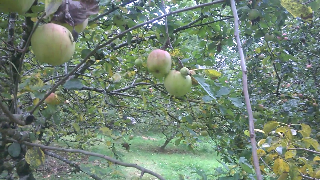

inference took: 3.67624568939209  seconds
num_detections: 100
Detection Classes:  [16 37 16 53 16 16 16  1 16 16 16 16 16 16 16 16 16  1 16 53 55  1 16 16
 53 16 16 16 53 64 16 16 16 16 16 16 16  1 16 64 53 16 16 16 16 53 16 16
 16 16 16 64 16  1 16 64 53 16 16  1 16  1 53 16  1 16 16  1 53 16 53 16
 16 16  1  1 16 16 16 53 16 56  1 16 64 16 53 16 16  1  1 16 20 16 16 16
  1 16 16 56]
Detection Scores:  [0.6605421  0.6032355  0.2591498  0.23718148 0.21867251 0.18965271
 0.14397821 0.10089225 0.09950581 0.0908038  0.08826053 0.08164844
 0.08044454 0.07867241 0.0764825  0.07582748 0.07557127 0.07003728
 0.06870323 0.06437638 0.0623194  0.06189635 0.06003281 0.0600076
 0.05633333 0.05596238 0.05500117 0.0548552  0.05459598 0.05402908
 0.05351469 0.05298907 0.05265141 0.05208102 0.0517306  0.05171582
 0.04769906 0.04649317 0.0463945  0.04581374 0.04569286 0.04565728
 0.04479629 0.04466671 0.0434517  0.04331872 0.04282361 0.04262781
 0.04252142 0.04202047 0.04187936 0.04142001 0.04132918 0.

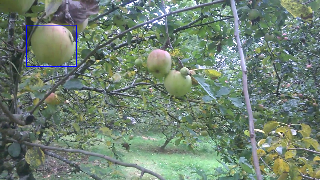

"\nclip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5) # <----- First 5 seconds\noutput_clip = clip1.fl_image(pipeline)\noutput_clip.write_videofile(base_dir + 'output_clip_TEST.mp4', audio = False)\n"

In [29]:
# the pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2



my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


# pipeline


def pipeline(frame) :
  
  #Step 1: Run inference and get bounding box data
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True) # True)
  
  #Step 2: Overlay the bounding boxes and generate cropped sub-images
  # I return final image here to allow for display you may not need to
  step_2_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = False ) #True)
  
  # Optional Display After Step 2:
  #cv2_imshow(step_2_image) #full size (Big)
  #cv2_imshow( cv2.resize(step_2_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #resized

  # Step 3: Run classifer on detected object
  step_3_image = my_classifier.draw_positive_boxes(step_2_image, object_data,object_images, show_results = True)
  #cv2_imshow( cv2.resize(step_3_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return step_3_image
  #return step_2_image # use to make video of step 2 results


# SINGLE FRAME FOR TEST
# to test one one frame use this
clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(19)#3) #19

#Beware a single frame colour scheme is different!
#Before processing
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

single_processed_image = pipeline(frame)
cv2_imshow( cv2.resize(single_processed_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


# CLIP , use subclip for reduce size, full video over 1 and a half minutes
#
'''
clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5) # <----- First 5 seconds
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_TEST.mp4', audio = False)
'''
